In [1]:
import keras

Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5103)
/home/joakim/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
path = "data/"
model_path = "model/"
batch_size=10

In [3]:
import utils; reload(utils)
from utils import *
import bcolz
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division, print_function

In [21]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size, shuffle=False)

#(val_classes, trn_classes, val_labels, trn_labels, 
#    val_filenames, filenames, test_filenames) = get_classes(path)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [7]:
imgs,labels = next(batches)

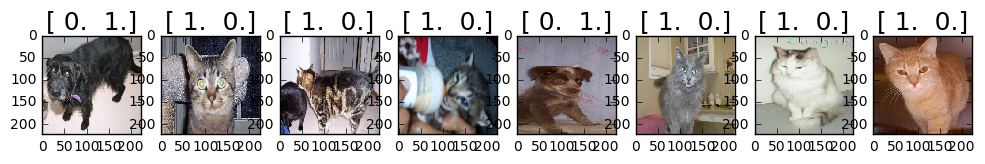

In [8]:
plots(imgs, titles=labels)

In [5]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN()

/home/joakim/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [10]:
vgg.predict(imgs, True)

(array([ 0.897 ,  0.4211,  0.9028,  0.2857,  0.5628,  0.5527,  0.3675,  0.3215], dtype=float32),
 array([197, 285, 281, 182, 151, 283, 285, 285]),
 [u'giant_schnauzer',
  u'Egyptian_cat',
  u'tabby',
  u'Border_terrier',
  u'Chihuahua',
  u'Persian_cat',
  u'Egyptian_cat',
  u'Egyptian_cat'])

In [6]:
vgg.finetune(batches)

In [23]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
20000/20000 [==============================] - 398s - loss: 0.6564 - acc: 0.9427 - val_loss: 0.2481 - val_acc: 0.9776

In [24]:
vgg.model.save_weights(path+'models/vgg16_bn.h5')

In [26]:
test_batches = get_batches(path+'test', batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [38]:
test_path = path + "test/"

In [33]:
batches, preds = vgg.test(test_path, batch_size = batch_size)

Found 12500 images belonging to 1 classes.


In [7]:
vgg.model.load_weights(path+'models/vgg16_bn.h5')

In [35]:
results_path = "results/"
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

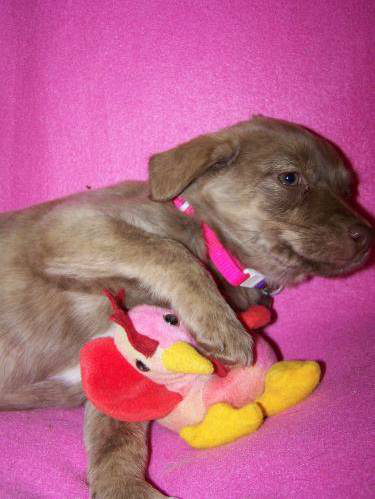

In [41]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + batches.filenames[1])

In [42]:
isdog = preds[:,1]

In [43]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [44]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [45]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  4.0680e+03,   5.0000e-02],
       [  5.9930e+03,   9.5000e-01],
       [  3.6040e+03,   5.0000e-02],
       [  7.2650e+03,   9.5000e-01],
       [  5.8700e+03,   5.0000e-02]])

In [46]:
submission_file_name = results_path + 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')